In [1]:
from functions import *
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import shap
from collections import Counter

## Data Preprocessing

In [2]:
path_1 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem1.csv"
path_2 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem2.csv"
path_3 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem3.csv"
path_4 = "/Users/rajwaghela/Library/CloudStorage/GoogleDrive-rajwaghela4244@gmail.com/My Drive/Thesis/Practical/Data/Vectors/sem4.csv"

BHT_1 = pd.read_csv(path_1, sep=';')
BHT_2 = pd.read_csv(path_2, sep=',')
BHT_3 = pd.read_csv(path_3, sep=',')
BHT_4 = pd.read_csv(path_4, sep=',')

In [3]:
BHT_1 = BHT_1.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_2 = BHT_2.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_3 = BHT_3.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})
BHT_4 = BHT_4.drop(columns=['Unnamed: 0']).rename(columns={'label': 'status'})

In [4]:
BHT_1 = BHT_1[BHT_1['no_passed_courses_1']<=6]
BHT_2 = BHT_2[(BHT_2['no_passed_courses_2']<=12) & (BHT_2['no_passed_courses_1']<=6)]
BHT_3 = BHT_3[(BHT_3['no_passed_courses_2']<=12) & (BHT_3['no_passed_courses_1']<=6)]
BHT_4 = BHT_4[(BHT_4['no_passed_courses_2']<=12) & (BHT_4['no_passed_courses_1']<=6)]


In [5]:
### swaping values
# after swaping, '1' is -> 'dropout' & '0'a is ->'graduate'
BHT_1['status'] = BHT_1['status'].replace([0, 1], [1, 0])
BHT_2['status'] = BHT_2['status'].replace([0, 1], [1, 0])
BHT_3['status'] = BHT_3['status'].replace([0, 1], [1, 0])
BHT_4['status'] = BHT_4['status'].replace([0, 1], [1, 0])

In [6]:
features_bht1 = BHT_1.columns[1:-1]
features_bht2 = BHT_2.columns[1:-1]
features_bht3 = BHT_3.columns[1:-1]
features_bht4 = BHT_4.columns[1:-1]

### Search Space / Param Grid 

In [7]:
from hyperopt import *
search_space = {
    'fit_intercept': hp.choice('fit_intercept', [True]),
    'solver': hp.choice('solver', ['liblinear', 'lbfgs']),
    'C': hp.uniform('C', 0.005, 0.1),
    'penalty': hp.choice('penalty', ['l2']),
    'class_weight':'balanced',
}

## BHT semester 1

In [8]:
hpo = ModelTrainer(random_state=42)

# Count occurrences of each unique value in the 'status' column
counter_1 = Counter(BHT_1['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_1[1]} | 0: {counter_1[0]}')
x, y = hpo.split_data(BHT_1, features_bht1)

Quantity of Drop Out and Degree in THL-1: 
 1: 160 | 0: 96


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 41.88trial/s, best loss: -0.7576025641025641]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            16               04
	 actual 1            13               19

Model parameters:
{'C': 0.016535286091599422, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Balanced acc.: 69.68750%
Validation accuracy.: 67.30769%
Sensitivity score (for 1): 59.37500%
Specificity score (for 0): 80.00000%
F1 score.: 69.09091%
False prediction: 32.69231%

------------------------------------- Fold 2 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 53.35trial/s, best loss: -0.7

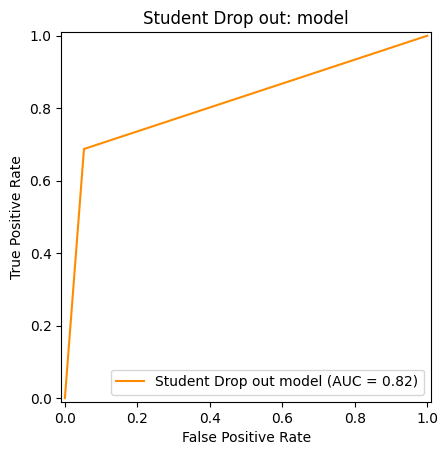

In [9]:
hpo = ModelTrainer(random_state=42)
model, feature_importance = hpo.cross_validation_hpo(
    x=x, y=y,
    search_space=search_space, 
    folds=5,
    algo='lr'
    )

In [10]:
feature_importance

,variable,coefficient
2,no_of_unattempted_courses_1,0.656350
3,avg_grade_all_courses_1,0.396910
1,no_of_failed_courses_1,0.288500
0,no_passed_courses_1,-0.436520


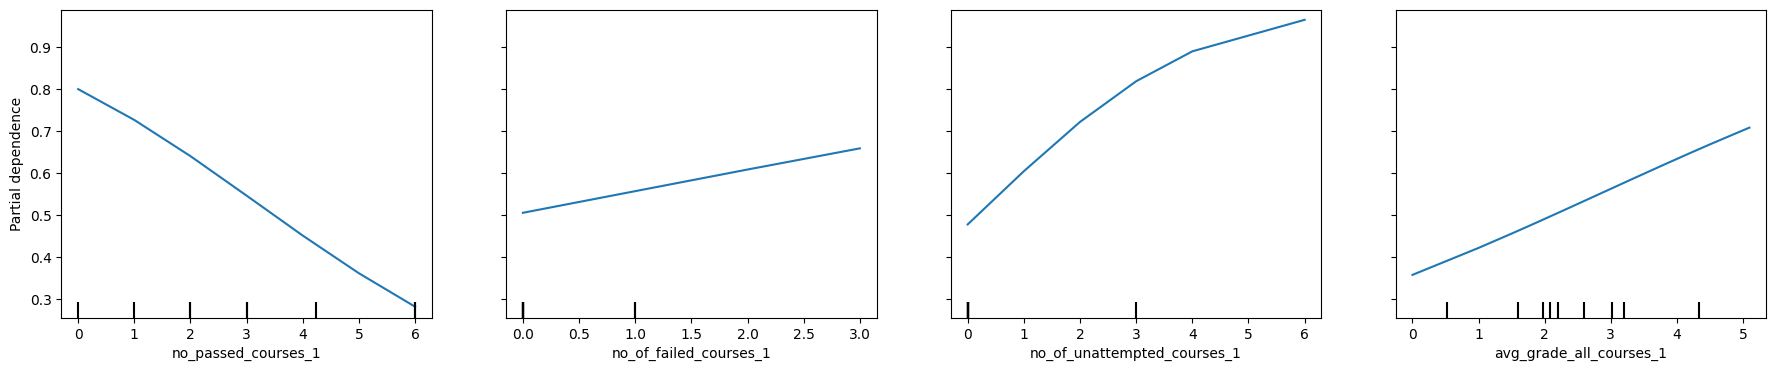

In [11]:
hpo.plot_partial_dependence(model=model, n_jobs=5, n_cols=6, size=1)

#### Shap analysis

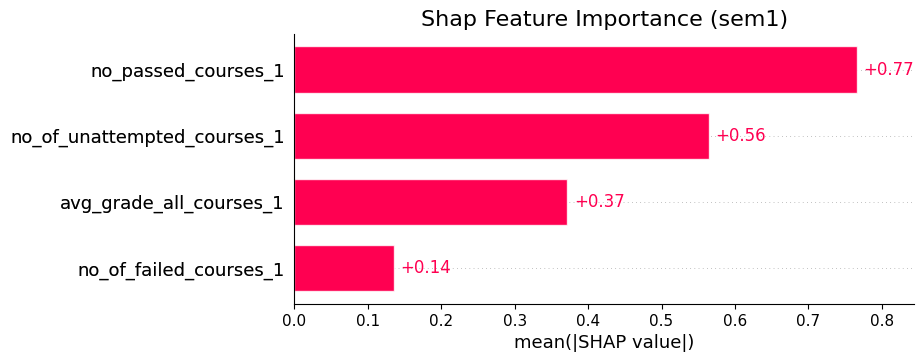

In [12]:
## Shap Global explainations
import shap
explainer = shap.Explainer(model['model'], model['x_train'])
shap_values = explainer(model['x_test'])

plt.title('Shap Feature Importance (sem1)', fontsize=16)
shap.plots.bar(shap_values)

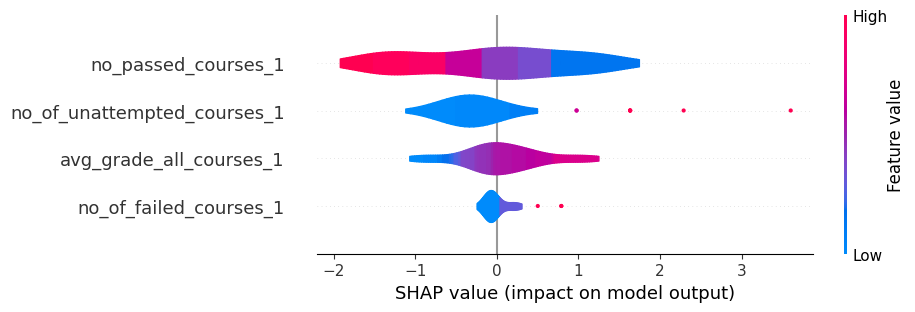

In [13]:
shap.plots.violin(shap_values, show=True)

In [14]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values, link='logit')

In [15]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=11, model_name='lr')

Student index 11 grades:
                             grades
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.2
Status: 0, Prediction: [0], Probability [0]: 0.675, Probability [1]: 0.325


In [16]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=12, model_name='lr')

Student index 12 grades:
                             grades
no_passed_courses_1             2.0
no_of_failed_courses_1          3.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         4.2
Status: 1, Prediction: [1], Probability [0]: 0.137, Probability [1]: 0.863


In [17]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=39, model_name='lr')

Student index 39 grades:
                             grades
no_passed_courses_1             0.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     4.0
avg_grade_all_courses_1         0.0
Status: 1, Prediction: [1], Probability [0]: 0.057, Probability [1]: 0.943


In [18]:
hpo.plot_shap_force(model=model, shap_values=shap_values, student_index=46, model_name='lr')

Student index 46 grades:
                             grades
no_passed_courses_1             0.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     3.0
avg_grade_all_courses_1         5.0
Status: 1, Prediction: [1], Probability [0]: 0.012, Probability [1]: 0.988


## BHT semester 2 

In [19]:
# Count occurrences of each unique value in the 'status' column
counter_2 = Counter(BHT_2['status'])
print(f'Quantity of Drop Out and Degree in THL-2: \n 1: {counter_2[1]} | 0: {counter_2[0]}')
hpo2 = ModelTrainer(random_state=69)
x2, y2 = hpo2.split_data(BHT_2, features_bht2)

Quantity of Drop Out and Degree in THL-2: 
 1: 102 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 39.75trial/s, best loss: -0.8372549019607843]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            15               04
	 actual 1            08               13

Model parameters:
{'C': 0.03361696408806825, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Balanced acc.: 70.42607%
Validation accuracy.: 70.00000%
Sensitivity score (for 1): 61.90476%
Specificity score (for 0): 78.94737%
F1 score.: 68.42105%
False prediction: 30.00000%

------------------------------------- Fold 2 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 50.91trial/s, best loss: -0.79

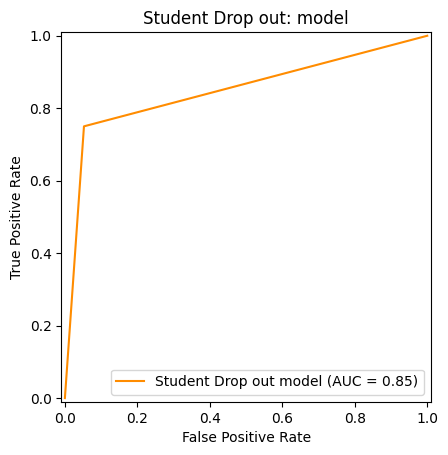

In [20]:
model_2, feature_importance_2 = hpo2.cross_validation_hpo(
    x=x2, y=y2,
    search_space=search_space, 
    folds=5,
    algo='lr'
    )

In [21]:
feature_importance_2

,variable,coefficient
2,no_of_unattempted_courses_2,0.375620
7,avg_grade_all_courses_1,0.330880
6,no_of_unattempted_courses_1,0.245550
1,no_of_failed_courses_2,0.243600
3,avg_grade_all_courses_2,0.178530
5,no_of_failed_courses_1,0.148860
4,no_passed_courses_1,-0.209750
0,no_passed_courses_2,-0.296400


#### Shap analysis

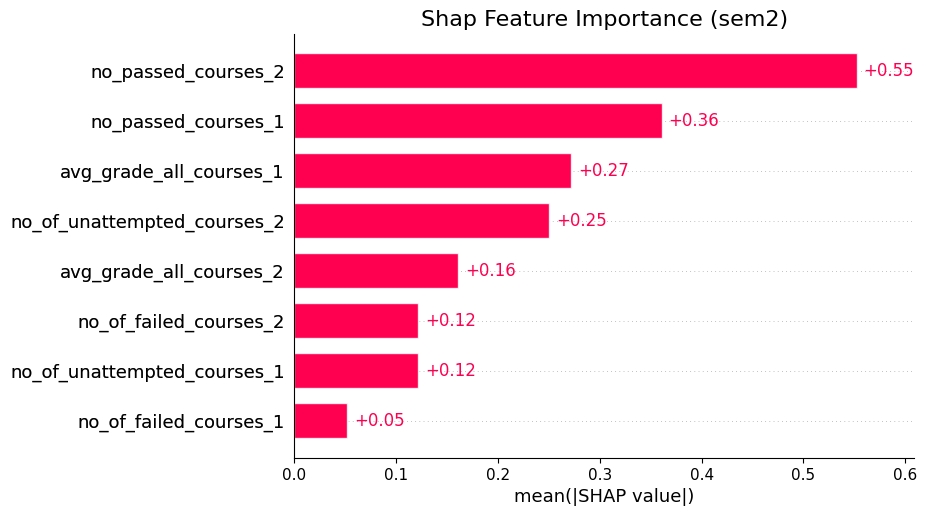

In [22]:
## Shap Global explainations
import shap
explainer2 = shap.Explainer(model_2['model'], model_2['x_train'])
shap_values2 = explainer2(model_2['x_test'])

plt.title('Shap Feature Importance (sem2)', fontsize=16)
shap.plots.bar(shap_values2)

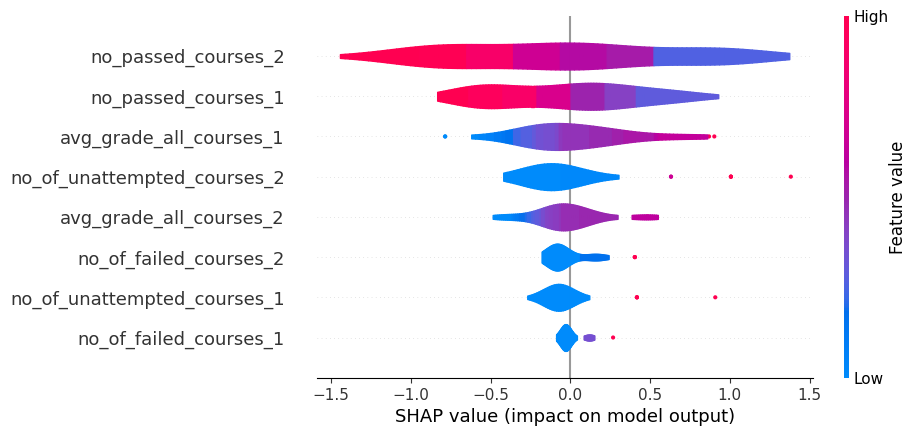

In [23]:
shap.plots.violin(shap_values2, show=True)

In [24]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values2, link='logit')

In [25]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=20, model_name='lr')

Student index 20 grades:
                             grades
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.9
no_passed_courses_1             5.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.1
Status: 0, Prediction: [0], Probability [0]: 0.762, Probability [1]: 0.238


In [26]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=5, model_name='lr')

Student index 5 grades:
                             grades
no_passed_courses_2             3.0
no_of_failed_courses_2          1.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.5
no_passed_courses_1             3.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.8
Status: 1, Prediction: [1], Probability [0]: 0.430, Probability [1]: 0.570


In [27]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=6, model_name='lr')

Student index 6 grades:
                             grades
no_passed_courses_2             0.0
no_of_failed_courses_2          2.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         5.0
no_passed_courses_1             2.0
no_of_failed_courses_1          1.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         3.2
Status: 1, Prediction: [1], Probability [0]: 0.099, Probability [1]: 0.901


In [28]:
hpo2.plot_shap_force(model=model_2, shap_values=shap_values2, student_index=10, model_name='lr')

Student index 10 grades:
                             grades
no_passed_courses_2             6.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.0
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.5
Status: 0, Prediction: [0], Probability [0]: 0.860, Probability [1]: 0.140


## BHT semester 3

In [29]:
# Count occurrences of each unique value in the 'status' column
counter_3 = Counter(BHT_3['status'])
print(f'Quantity of Drop Out and Degree in THL-1: \n 1: {counter_3[1]} | 0: {counter_3[0]}')
# Count occurrences of each unique value in the 'status' column
hpo3 = ModelTrainer(random_state=42)
x3, y3 = hpo3.split_data(BHT_3, features_bht3)

Quantity of Drop Out and Degree in THL-1: 
 1: 71 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 46.83trial/s, best loss: -0.8434469696969698]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            18               01
	 actual 1            04               11

Model parameters:
{'C': 0.03305498319852597, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Balanced acc.: 84.03509%
Validation accuracy.: 85.29412%
Sensitivity score (for 1): 73.33333%
Specificity score (for 0): 94.73684%
F1 score.: 81.48148%
False prediction: 14.70588%

------------------------------------- Fold 2 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 51.19trial/s, best loss: -0.83

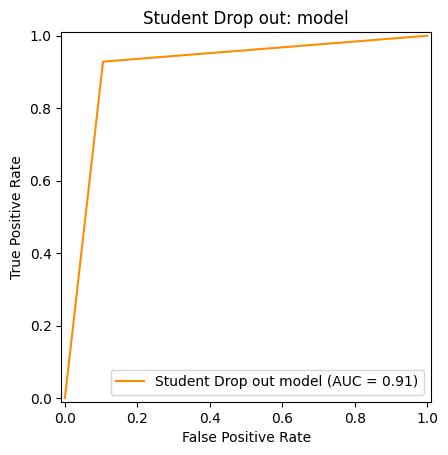

In [30]:
model_3, feature_importance_3 = hpo3.cross_validation_hpo(
    x=x3, y=y3,
    search_space=search_space, 
    folds=5,
    algo='lr'
    )

In [31]:
feature_importance_3

,variable,coefficient
11,avg_grade_all_courses_1,0.335810
6,no_of_unattempted_courses_2,0.253340
7,avg_grade_all_courses_2,0.245800
5,no_of_failed_courses_2,0.196460
2,no_of_unattempted_courses_3,0.176420
10,no_of_unattempted_courses_1,0.125700
9,no_of_failed_courses_1,0.090810
1,no_of_failed_courses_3,0.057450
3,avg_grade_all_courses_3,-0.003100
8,no_passed_courses_1,-0.132400


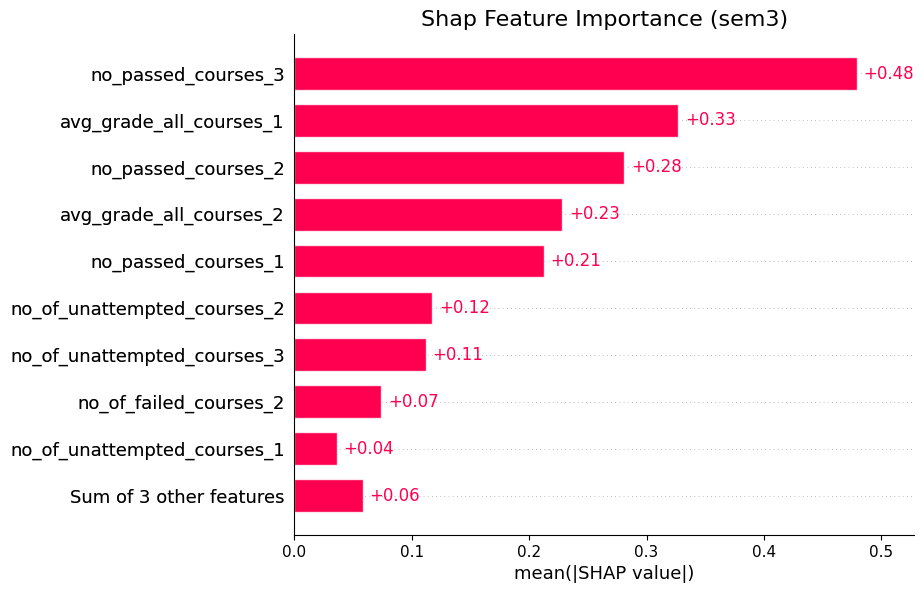

In [32]:
## Shap Global explainations
import shap
explainer3 = shap.Explainer(model_3['model'], model_3['x_train'])
shap_values3 = explainer3(model_3['x_test'])

plt.title('Shap Feature Importance (sem3)', fontsize=16)
shap.plots.bar(shap_values3)

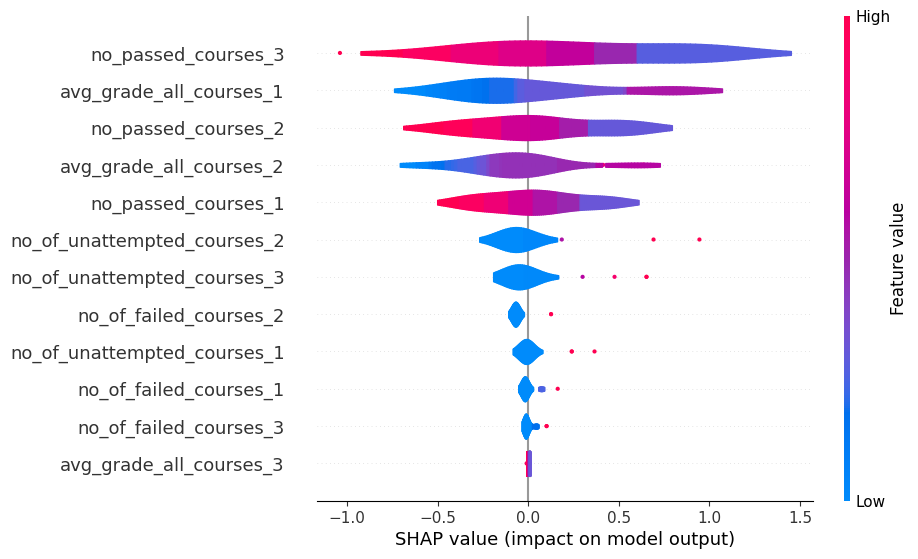

In [33]:
shap.plots.violin(shap_values3, show=True)

In [34]:
## Local explainations
shap.initjs()
shap.force_plot(shap_values3, link='logit')

In [35]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=1, model_name='lr')

Student index 1 grades:
                             grades
no_passed_courses_3             3.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.6
no_passed_courses_2             7.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.3
no_passed_courses_1             1.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.727, Probability [1]: 0.273


In [36]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=9, model_name='lr')

Student index 9 grades:
                             grades
no_passed_courses_3             5.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         2.3
no_passed_courses_2             3.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.6
no_passed_courses_1             2.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.5
Status: 0, Prediction: [0], Probability [0]: 0.622, Probability [1]: 0.378


In [37]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=3, model_name='lr')

Student index 3 grades:
                             grades
no_passed_courses_3             4.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         2.8
no_passed_courses_2             4.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.3
no_passed_courses_1             4.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         2.0
Status: 0, Prediction: [0], Probability [0]: 0.713, Probability [1]: 0.287


In [38]:
hpo3.plot_shap_force(model=model_3, shap_values=shap_values3, student_index=10, model_name='lr')

Student index 10 grades:
                             grades
no_passed_courses_3             0.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     1.0
avg_grade_all_courses_3         0.0
no_passed_courses_2             2.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         1.7
no_passed_courses_1             3.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.5
Status: 1, Prediction: [1], Probability [0]: 0.389, Probability [1]: 0.611


## BHT semester 4

In [39]:
# Count occurrences of each unique value in the 'status' column
counter_4 = Counter(BHT_4['status'])
print(f'Quantity of Drop Out and Degree in THL-4: \n 1: {counter_4[1]} | 0: {counter_4[0]}')
# Count occurrences of each unique value in the 'status' column
hpo4 = ModelTrainer(random_state=42)
x4, y4 = hpo4.split_data(BHT_4, features_bht4)


Quantity of Drop Out and Degree in THL-4: 
 1: 59 | 0: 95


------------------------------------- Fold 1 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 41.43trial/s, best loss: -0.838611111111111]

Confusion Matrix
	                 predicted 0     predicted 1
	 actual 0            16               03
	 actual 1            03               09

Model parameters:
{'C': 0.05669479574449924, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Balanced acc.: 79.60526%
Validation accuracy.: 80.64516%
Sensitivity score (for 1): 75.00000%
Specificity score (for 0): 84.21053%
F1 score.: 75.00000%
False prediction: 19.35484%

------------------------------------- Fold 2 --------------------------------------------------
100%|██████████| 10/10 [00:00<00:00, 44.24trial/s, best loss: -0.8545833

,variable,coefficient
3,avg_grade_all_courses_4,0.196130
15,avg_grade_all_courses_1,0.180010
2,no_of_unattempted_courses_4,0.170440
10,no_of_unattempted_courses_2,0.133610
11,avg_grade_all_courses_2,0.120510
9,no_of_failed_courses_2,0.080280
13,no_of_failed_courses_1,0.076040
6,no_of_unattempted_courses_3,0.075380
1,no_of_failed_courses_4,0.061760
14,no_of_unattempted_courses_1,0.057450


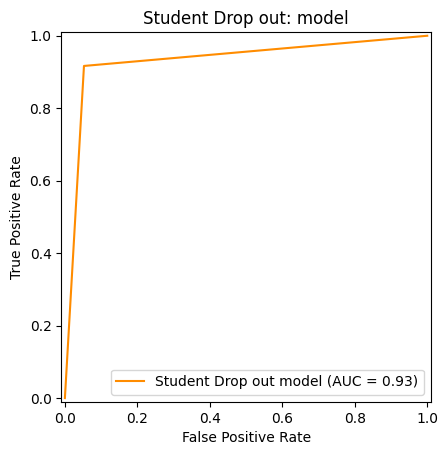

In [40]:
model_4, feature_importance_4 = hpo4.cross_validation_hpo(
    x=x4, y=y4,
    search_space=search_space, 
    folds=5,
    algo='lr'
    )
feature_importance_4

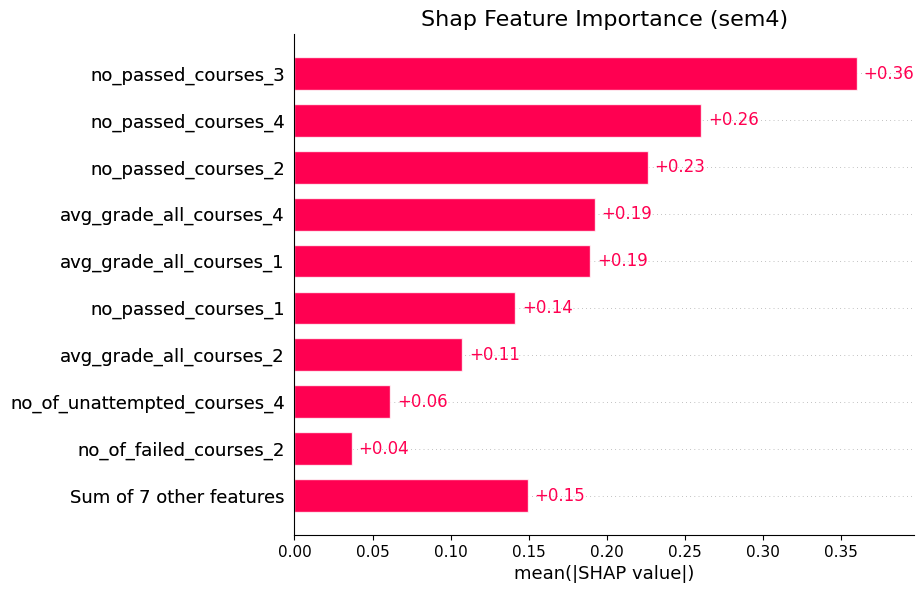

In [41]:
# Shap Global explainations
import shap
explainer4 = shap.Explainer(model_4['model'], model_4['x_train'])
shap_values4 = explainer4(model_4['x_test'])

plt.title('Shap Feature Importance (sem4)', fontsize=16)
shap.plots.bar(shap_values4)

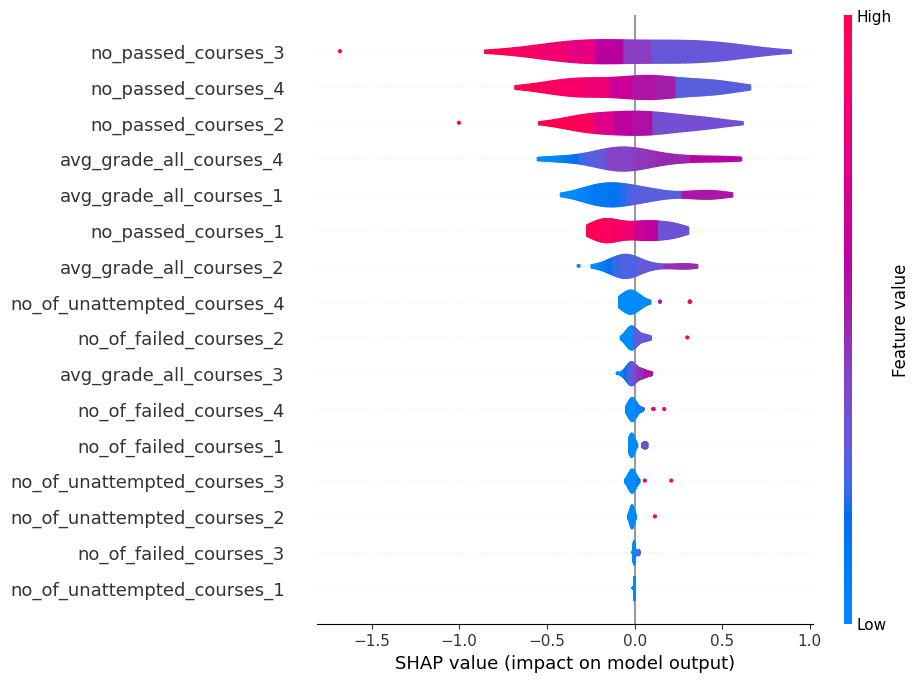

In [42]:
shap.plots.violin(shap_values4, show=True)

In [43]:
# Local explainations
shap.initjs()
shap.force_plot(shap_values4, link='logit')

In [44]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=1, model_name='lr')

Student index 1 grades:
                             grades
no_passed_courses_4             0.0
no_of_failed_courses_4          3.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         5.0
no_passed_courses_3             0.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         5.1
no_passed_courses_2             0.0
no_of_failed_courses_2          0.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         5.1
no_passed_courses_1             0.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         5.1
Status: 1, Prediction: [1], Probability [0]: 0.051, Probability [1]: 0.949


In [55]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=7, model_name='lr')


Student index 7 grades:
                             grades
no_passed_courses_4             2.0
no_of_failed_courses_4          1.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         3.3
no_passed_courses_3             1.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.0
no_passed_courses_2             2.0
no_of_failed_courses_2          1.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         3.0
no_passed_courses_1             0.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         5.1
Status: 1, Prediction: [1], Probability [0]: 0.184, Probability [1]: 0.816


In [49]:
hpo4.plot_shap_force(model=model_4, shap_values=shap_values4, student_index=5, model_name='lr')


Student index 5 grades:
                             grades
no_passed_courses_4             8.0
no_of_failed_courses_4          0.0
no_of_unattempted_courses_4     0.0
avg_grade_all_courses_4         2.0
no_passed_courses_3             8.0
no_of_failed_courses_3          0.0
no_of_unattempted_courses_3     0.0
avg_grade_all_courses_3         1.6
no_passed_courses_2             4.0
no_of_failed_courses_2          1.0
no_of_unattempted_courses_2     0.0
avg_grade_all_courses_2         2.4
no_passed_courses_1             6.0
no_of_failed_courses_1          0.0
no_of_unattempted_courses_1     0.0
avg_grade_all_courses_1         1.6
Status: 0, Prediction: [0], Probability [0]: 0.886, Probability [1]: 0.114
